In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : [],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_e_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 937)
(631390, 1)
validation
(74368, 937)
(74368, 1)
test
(85358, 937)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 937)]             0         


 dense (Dense)               (None, 1024)              960512    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1649665 (6.29 MB)


Trainable params: 1649665 (6.29 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:22 - loss: 0.0167 - STD: 9.4058e-05 - MAE: 0.0685

 4/64 [>.............................] - ETA: 1s - loss: 0.0175 - STD: 4.5039e-04 - MAE: 0.0913  

 7/64 [==>...........................] - ETA: 1s - loss: 0.0171 - STD: 8.0263e-04 - MAE: 0.0827

10/64 [===>..........................] - ETA: 1s - loss: 0.0160 - STD: 0.0013 - MAE: 0.0833    

13/64 [=====>........................] - ETA: 1s - loss: 0.0154 - STD: 0.0017 - MAE: 0.0841

16/64 [======>.......................] - ETA: 1s - loss: 0.0149 - STD: 0.0021 - MAE: 0.0794

19/64 [=======>......................] - ETA: 1s - loss: 0.0145 - STD: 0.0025 - MAE: 0.0763

22/64 [=========>....................] - ETA: 0s - loss: 0.0142 - STD: 0.0031 - MAE: 0.0765

25/64 [==========>...................] - ETA: 0s - loss: 0.0139 - STD: 0.0038 - MAE: 0.0764

28/64 [============>.................] - ETA: 0s - loss: 0.0136 - STD: 0.0046 - MAE: 0.0744

31/64 [=============>................] - ETA: 0s - loss: 0.0133 - STD: 0.0057 - MAE: 0.0727

34/64 [==============>...............] - ETA: 0s - loss: 0.0130 - STD: 0.0074 - MAE: 0.0721

37/64 [================>.............] - ETA: 0s - loss: 0.0126 - STD: 0.0096 - MAE: 0.0709

40/64 [=================>............] - ETA: 0s - loss: 0.0122 - STD: 0.0124 - MAE: 0.0692

42/64 [==================>...........] - ETA: 0s - loss: 0.0121 - STD: 0.0148 - MAE: 0.0683

45/64 [====================>.........] - ETA: 0s - loss: 0.0116 - STD: 0.0189 - MAE: 0.0671

48/64 [=====================>........] - ETA: 0s - loss: 0.0112 - STD: 0.0229 - MAE: 0.0658

51/64 [======================>.......] - ETA: 0s - loss: 0.0108 - STD: 0.0267 - MAE: 0.0645

54/64 [========================>.....] - ETA: 0s - loss: 0.0104 - STD: 0.0296 - MAE: 0.0632

56/64 [=========================>....] - ETA: 0s - loss: 0.0102 - STD: 0.0315 - MAE: 0.0623

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 0.0346 - MAE: 0.0611

62/64 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 0.0377 - MAE: 0.0601

64/64 [==============================] - 4s 41ms/step - loss: 0.0094 - STD: 0.0396 - MAE: 0.0593 - val_loss: 0.0049 - val_STD: 0.0708 - val_MAE: 0.0430


Epoch 2/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0937 - MAE: 0.0367

 3/64 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0921 - MAE: 0.0365

 6/64 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0931 - MAE: 0.0364

 9/64 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0951 - MAE: 0.0364

12/64 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0960 - MAE: 0.0361

15/64 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0960 - MAE: 0.0359

18/64 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0964 - MAE: 0.0358

21/64 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0969 - MAE: 0.0356

24/64 [==========>...................] - ETA: 0s - loss: 0.0031 - STD: 0.0971 - MAE: 0.0355

27/64 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0972 - MAE: 0.0354

30/64 [=============>................] - ETA: 0s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0353

33/64 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0977 - MAE: 0.0351

36/64 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0978 - MAE: 0.0350

39/64 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0979 - MAE: 0.0349

42/64 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0980 - MAE: 0.0348

45/64 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0981 - MAE: 0.0346

48/64 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0981 - MAE: 0.0345

51/64 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0983 - MAE: 0.0343

54/64 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0985 - MAE: 0.0342

56/64 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0986 - MAE: 0.0341

59/64 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0987 - MAE: 0.0340

61/64 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0988 - MAE: 0.0339

64/64 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0989 - MAE: 0.0338

64/64 [==============================] - 2s 28ms/step - loss: 0.0027 - STD: 0.0989 - MAE: 0.0338 - val_loss: 0.0027 - val_STD: 0.0818 - val_MAE: 0.0347


Epoch 3/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0318

 3/64 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.1020 - MAE: 0.0315

 5/64 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0314

 8/64 [==>...........................] - ETA: 1s - loss: 0.0021 - STD: 0.1021 - MAE: 0.0313

11/64 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0312

14/64 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.1020 - MAE: 0.0310

17/64 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0309

20/64 [========>.....................] - ETA: 0s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0307

23/64 [=========>....................] - ETA: 0s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0306

26/64 [===========>..................] - ETA: 0s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0305

29/64 [============>.................] - ETA: 0s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0304

32/64 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0303

36/64 [===============>..............] - ETA: 0s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0302

39/64 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0301

42/64 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0300

45/64 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0300

48/64 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0300

51/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0300

54/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0300

57/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0300

60/64 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0300

63/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0299

64/64 [==============================] - 2s 25ms/step - loss: 0.0019 - STD: 0.1029 - MAE: 0.0299 - val_loss: 0.0019 - val_STD: 0.0899 - val_MAE: 0.0301


Epoch 4/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0294

 4/64 [>.............................] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0298

 7/64 [==>...........................] - ETA: 1s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0299

10/64 [===>..........................] - ETA: 1s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0298

13/64 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0296

16/64 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0294

18/64 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0293

21/64 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0291

24/64 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0290

27/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0289

30/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0288

32/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0288

36/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0287

39/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0287

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

45/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

48/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0284

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0284

64/64 [==============================] - 2s 27ms/step - loss: 0.0017 - STD: 0.1045 - MAE: 0.0284 - val_loss: 0.0020 - val_STD: 0.0957 - val_MAE: 0.0305


Epoch 5/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1086 - MAE: 0.0272

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0277

 7/64 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

10/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0275

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0276

16/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0276

18/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0276

21/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0277

24/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

27/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

30/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

33/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

36/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

64/64 [==============================] - 2s 27ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277 - val_loss: 0.0016 - val_STD: 0.0899 - val_MAE: 0.0283


Epoch 6/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.0993 - MAE: 0.0294

 3/64 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0289

 6/64 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0280

 9/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

12/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

15/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0273

18/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

21/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

24/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

27/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

30/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

33/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

36/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

64/64 [==============================] - 2s 26ms/step - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275 - val_loss: 0.0017 - val_STD: 0.0947 - val_MAE: 0.0285


Epoch 7/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0273

 3/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0275

 6/64 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0274

 9/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

12/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0273

15/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0272

18/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0273

20/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

23/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0271

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0271

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270 - val_loss: 0.0017 - val_STD: 0.0954 - val_MAE: 0.0282


Epoch 8/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0281

 6/64 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0282

 9/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0280

12/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

15/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

18/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

21/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

24/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

27/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

64/64 [==============================] - 2s 27ms/step - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271 - val_loss: 0.0015 - val_STD: 0.0923 - val_MAE: 0.0275


Epoch 9/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0267

 3/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

 6/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

12/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

18/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

20/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

23/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

32/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267 - val_loss: 0.0018 - val_STD: 0.0981 - val_MAE: 0.0291


Epoch 10/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0014 - STD: 0.1129 - MAE: 0.0263

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1097 - MAE: 0.0263

 6/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1074 - MAE: 0.0267

12/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0266

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0266

18/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0268

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0267

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0267

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0267

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0268

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0267

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0267

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0268

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0268

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0267

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0267

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0267

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266 - val_loss: 0.0017 - val_STD: 0.0967 - val_MAE: 0.0288


Epoch 11/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

 3/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

 6/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0266

12/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

20/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

32/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267 - val_loss: 0.0015 - val_STD: 0.0957 - val_MAE: 0.0274


Epoch 12/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1038 - MAE: 0.0256

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0258

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

12/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0263

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0264

18/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0263

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0263

24/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0263

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0262

30/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0262

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0262

35/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0262

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0262

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0262

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0263

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

64/64 [==============================] - 2s 26ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262 - val_loss: 0.0021 - val_STD: 0.0996 - val_MAE: 0.0315


Epoch 13/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0268

 3/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

 6/64 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0279

 9/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0279

12/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

15/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

18/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

24/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

32/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

64/64 [==============================] - 2s 26ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265 - val_loss: 0.0016 - val_STD: 0.0952 - val_MAE: 0.0279


Epoch 14/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0258

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0261

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0264

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0264

18/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

24/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

36/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

39/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

64/64 [==============================] - 2s 24ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262 - val_loss: 0.0015 - val_STD: 0.0954 - val_MAE: 0.0275


Epoch 15/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0256

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

64/64 [==============================] - 2s 27ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262 - val_loss: 0.0016 - val_STD: 0.0949 - val_MAE: 0.0276


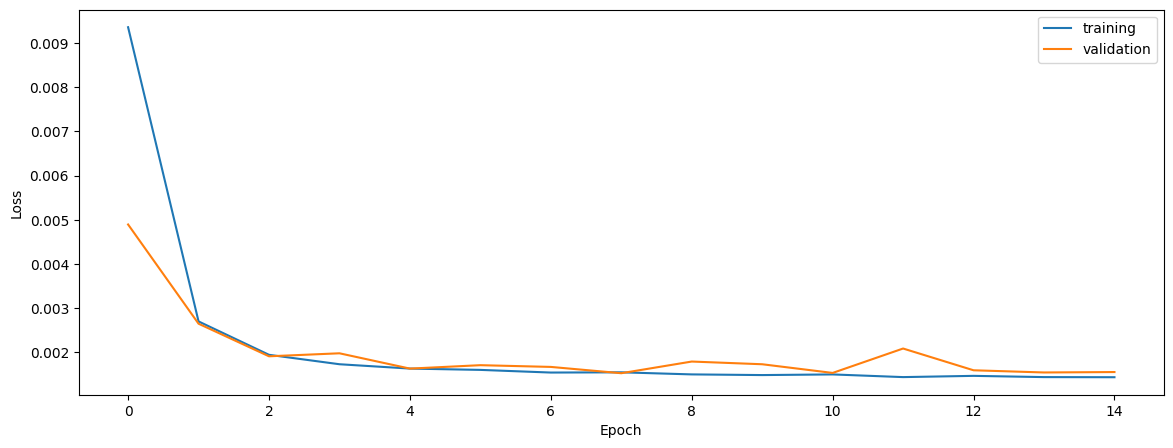

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9404414106905593
0.9533284664921968
0.9493086831023302


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9418623881574149
0.9512370095143793
0.9497176448354382


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9491649506562223
0.9536890025999489
0.9617042229636552


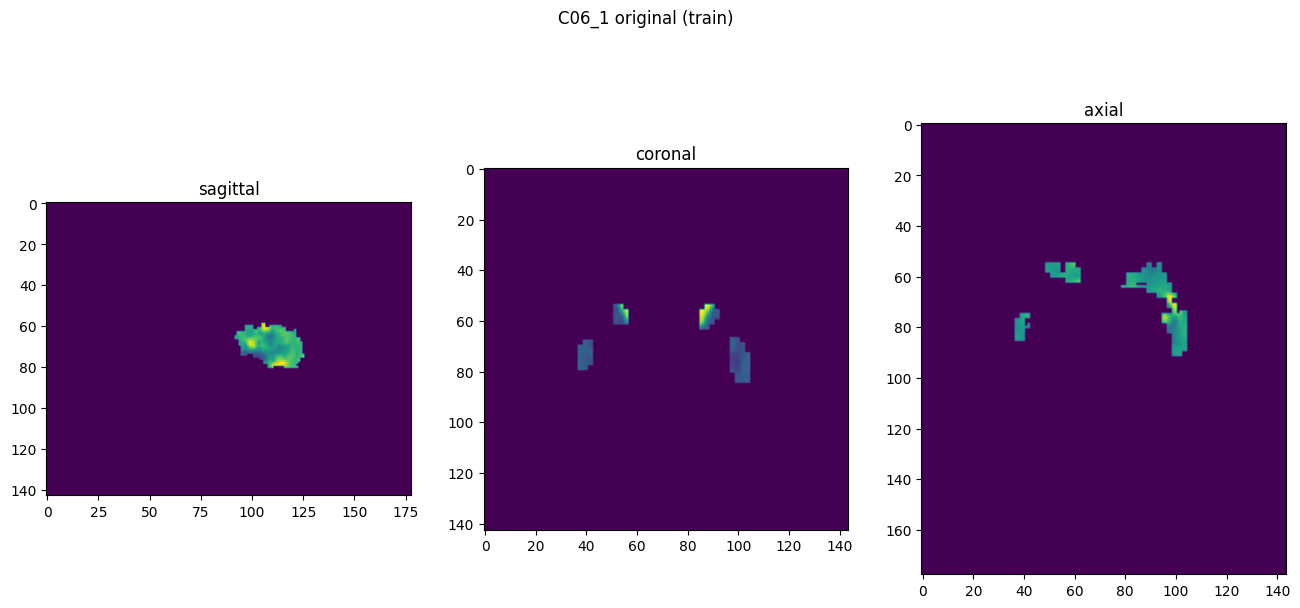

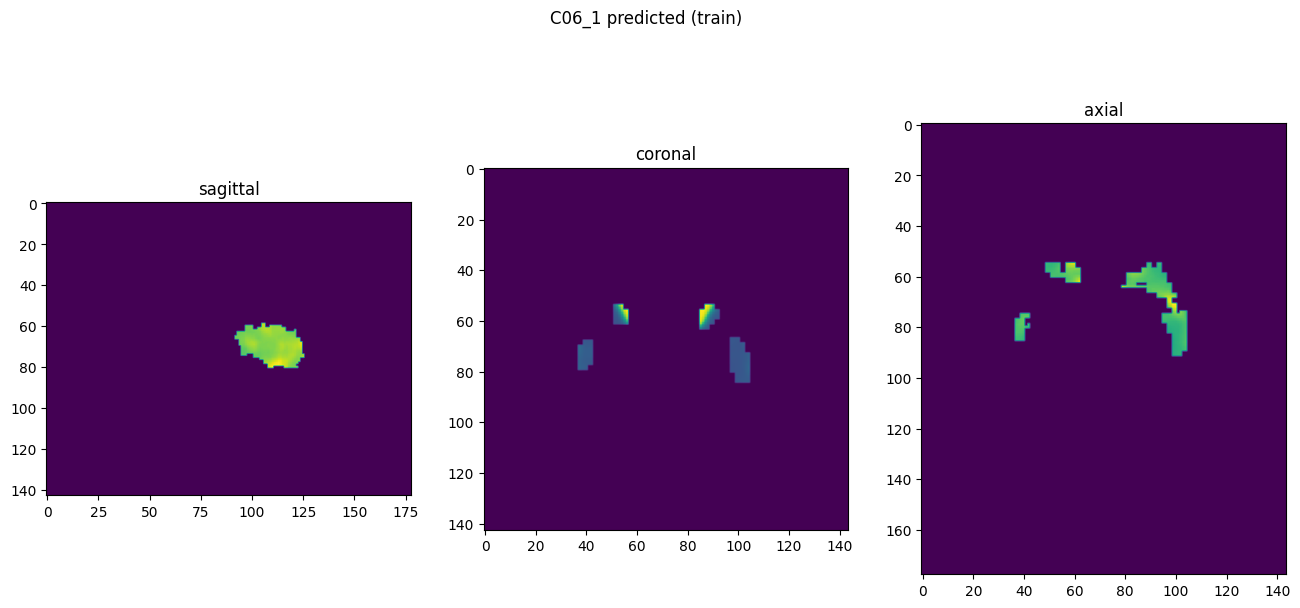

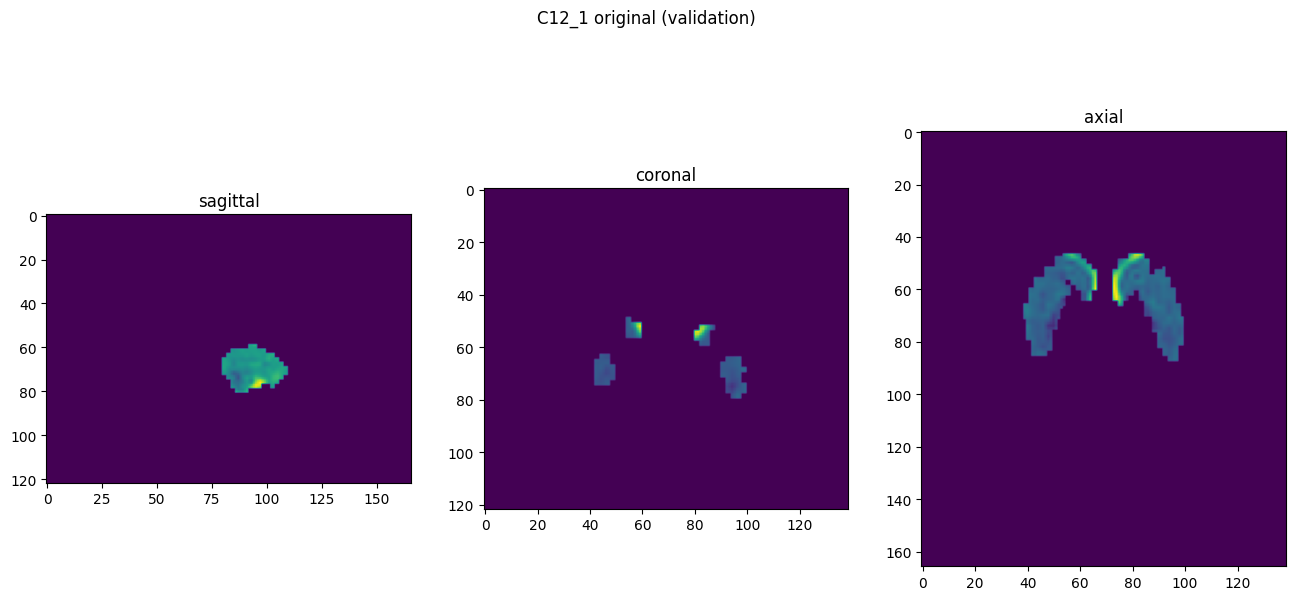

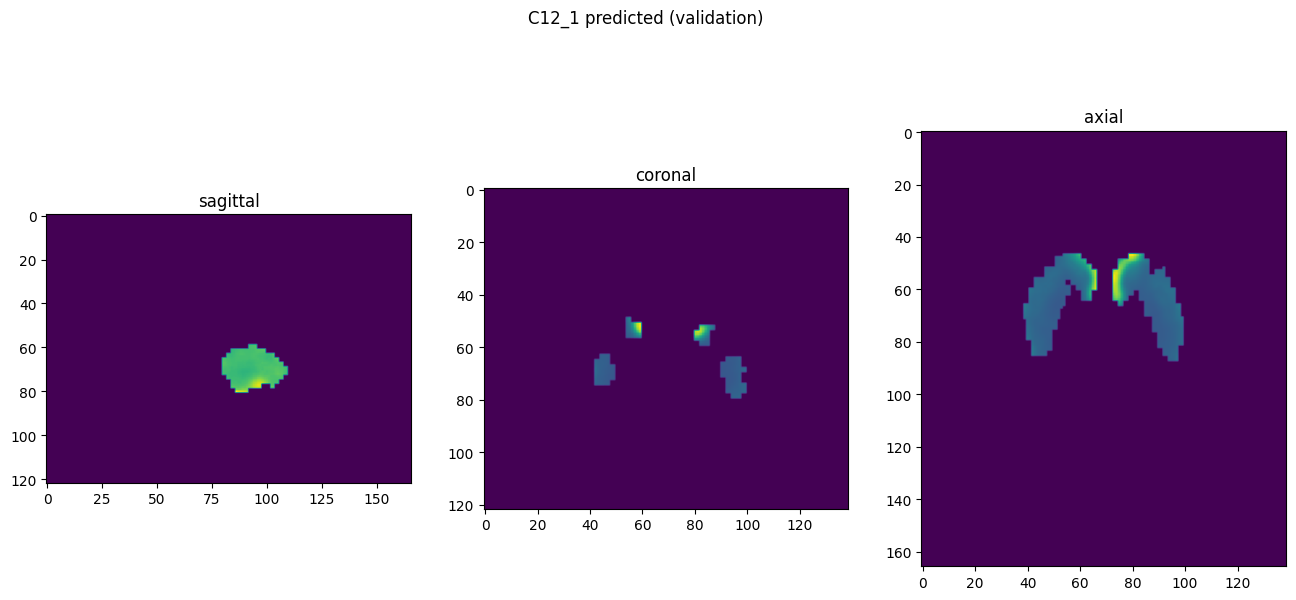

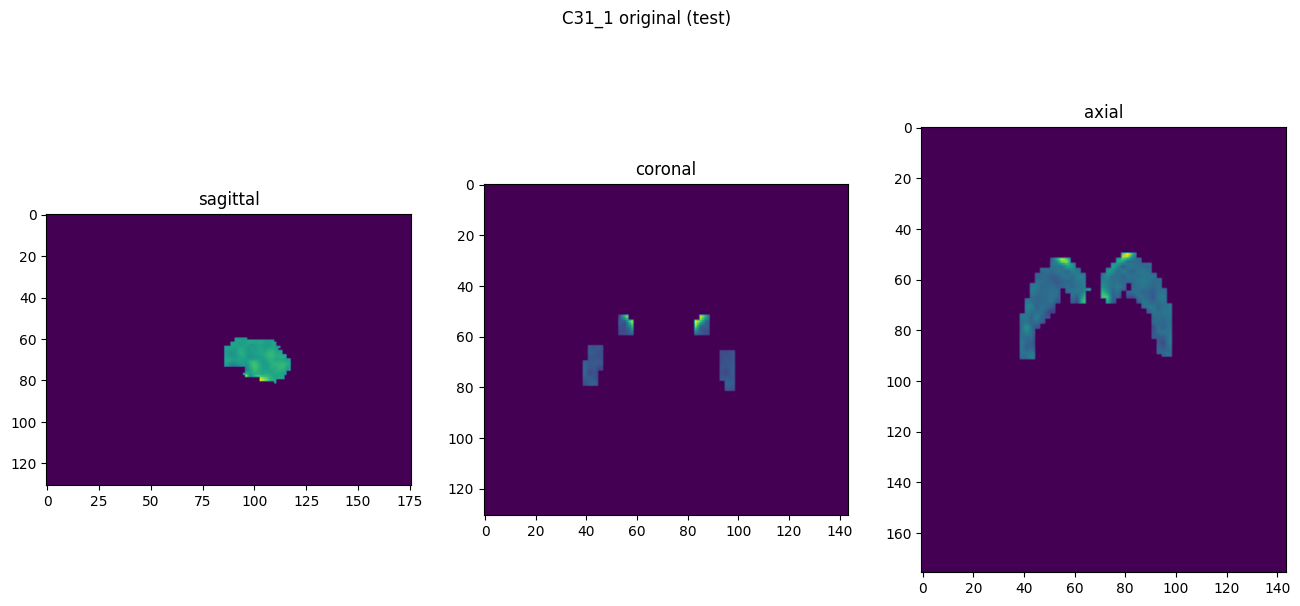

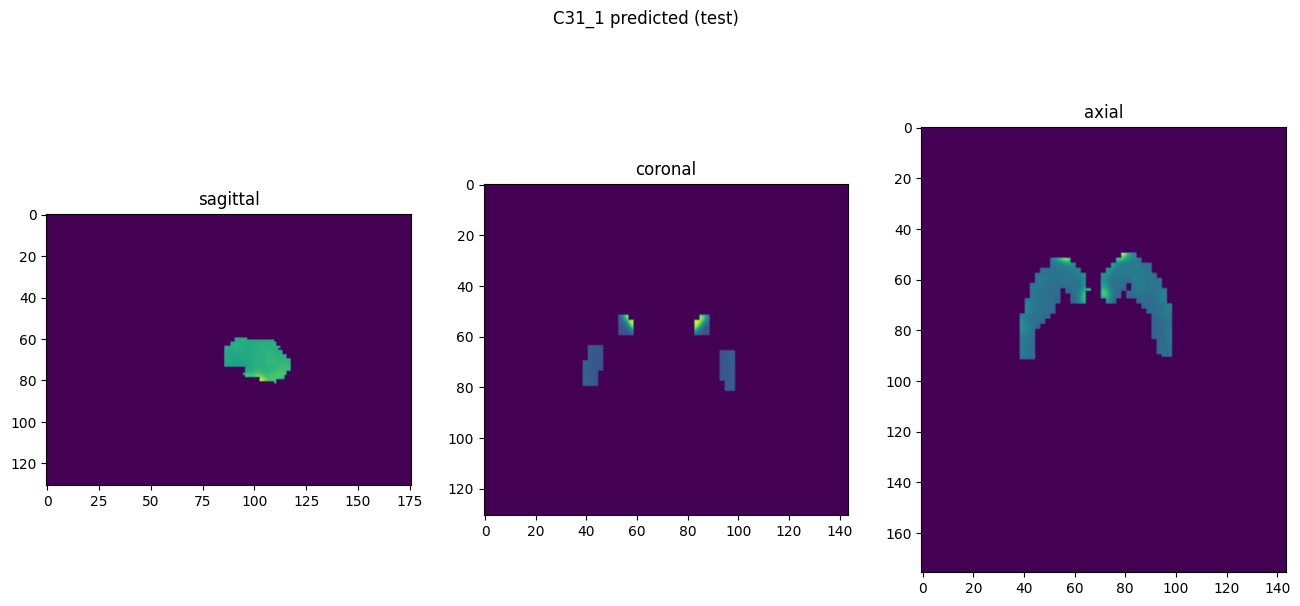

In [10]:
showResults(model, gen, threshold=None, background=False)